<a href="https://colab.research.google.com/github/Abdelhak-mekaoui/Titanic---Machine-Learning-from-Disaster/blob/main/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

## Importing the libraries

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Importing the dataset

In [189]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [190]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [191]:
for column in train_data.columns :
  if train_data[column].dtype == 'object' :
    print(f"{column} : {train_data[column].nunique()}")

Name : 891
Sex : 2
Ticket : 681
Cabin : 147
Embarked : 3


# Dealing with missing values

In [192]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

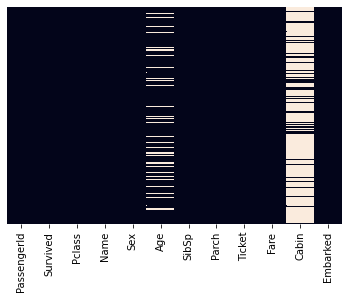

In [193]:
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False)

In [194]:
y=train_data.iloc[:,1].values

**Droping columns with large number of missing values**

In [195]:
columns_to_drop = ['PassengerId','Survived','Name','Ticket','Cabin']

In [196]:
train_data = train_data.drop(columns=columns_to_drop)
columns_to_drop.remove('Survived')
test_data = test_data.drop(columns=columns_to_drop)

In [197]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [198]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [199]:
categorical_columns=[]
numerical_columns=[]
categorical_columns_indexes=[]
numerical_columns_indexes=[]
for i,column in enumerate(train_data.columns) :
  if train_data[column].dtype == 'object' :
    categorical_columns.append(column)
    categorical_columns_indexes.append(i)
  else:
    numerical_columns.append(column)
    numerical_columns_indexes.append(i)

print(categorical_columns)
print(numerical_columns)
print(categorical_columns_indexes)
print(numerical_columns_indexes)

['Sex', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
[1, 6]
[0, 2, 3, 4, 5]


Fill in the missing values

In [200]:
X=train_data.iloc[:,:].values
X_test=test_data.iloc[:,:].values

In [201]:
print(X.shape)
print(y.shape)
print(X_test.shape)

(891, 7)
(891,)
(418, 7)


In [202]:
print(X[:5,:])

[[3 'male' 22.0 1 0 7.25 'S']
 [1 'female' 38.0 1 0 71.2833 'C']
 [3 'female' 26.0 0 0 7.925 'S']
 [1 'female' 35.0 1 0 53.1 'S']
 [3 'male' 35.0 0 0 8.05 'S']]


In [203]:
from sklearn.impute import SimpleImputer
si1=SimpleImputer(missing_values=np.nan,strategy='mean')
si2=SimpleImputer(missing_values=np.nan,strategy='most_frequent')

In [204]:
X[:,[2,5]] = si1.fit_transform(X[:,[2,5]])
X[:,[1,3,4,6]] = si2.fit_transform(X[:,[1,3,4,6]])

X_test[:,[2,5]] = si1.fit_transform(X_test[:,[2,5]])
X_test[:,[1,3,4,6]] = si2.fit_transform(X_test[:,[1,3,4,6]])

# OneHotEncoding and FeatureScaling

In [205]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
#Encoding and scaling the input variable
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(handle_unknown='ignore', sparse=False),[1,6])
                                     ,('scaler',StandardScaler(),[2,5])]
                       ,remainder='passthrough')
ct.fit(np.concatenate((X,X_test)))
X = np.array(ct.transform(X))
X_test = np.array(ct.transform(X_test))

In [206]:
print(X.shape)
print(y.shape)
print(X_test.shape)

(891, 10)
(891,)
(418, 10)


# Spliting the dataset into Train set and cross validation set

In [207]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Training the classification models on the training set

**RandomForestClassifier**

In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

max_depth=range(5,20)
min_samples_split=range(2,15)
J_train = []
J_cv = []
best = [5,2]
for md in max_depth:
  for ms in min_samples_split:
    print(f"\n==========================={md}============={ms}==========================\n")
    classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
                                        max_depth=md ,
                                        min_samples_split=ms ,
                                        random_state = 0)
    classifier.fit(X_train, y_train)
    y_pred_t = classifier.predict(X_train)
    y_pred_cv = classifier.predict(X_cv)
    cm = confusion_matrix(y_cv, y_pred_cv)
    print(cm)
    Rt = accuracy_score(y_train, y_pred_t)
    Rcv = accuracy_score(y_cv, y_pred_cv)
    print(f"Train score : {Rt} CV score {Rcv}")
    if md!=5 and ms!=2 and (Rcv > max(J_cv)) :
      best=[md,ms]
    J_train.append(Rt)
    J_cv.append(Rcv)
    



===========================5=============2==========================

[[97 13]
 [20 49]]
Train score : 0.8300561797752809 CV score 0.8156424581005587

===========================5=============3==========================

[[97 13]
 [21 48]]
Train score : 0.8300561797752809 CV score 0.8100558659217877

===========================5=============4==========================

[[97 13]
 [21 48]]
Train score : 0.8314606741573034 CV score 0.8100558659217877

===========================5=============5==========================

[[97 13]
 [21 48]]
Train score : 0.8328651685393258 CV score 0.8100558659217877

===========================5=============6==========================

[[97 13]
 [21 48]]
Train score : 0.8328651685393258 CV score 0.8100558659217877

===========================5=============7==========================

[[97 13]
 [21 48]]
Train score : 0.8328651685393258 CV score 0.8100558659217877

===========================5=============8==========================

[[96 14]
 [19 50]]
Trai

In [209]:
best

[14, 13]

**Naive Bayes**

In [210]:
from sklearn.naive_bayes import GaussianNB
classifier2 = GaussianNB()
classifier2.fit(X_train, y_train)

GaussianNB()

In [211]:
y_pred = classifier2.predict(X_cv)
cm = confusion_matrix(y_cv, y_pred)
print(cm)
accuracy_score(y_cv, y_pred)

[[91 19]
 [17 52]]


0.7988826815642458

In [212]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
                                        max_depth=best[0] ,
                                        min_samples_split=best[1] ,
                                        random_state = 0)
classifier.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=13,
                       n_estimators=10, random_state=0)

# Submission

In [213]:
y_pred=classifier.predict(X_test)

In [214]:
submission=gender_submission[['PassengerId']]
submission['Survived']=y_pred

In [215]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [217]:
submission.to_csv('submission.csv',index=False)